In [1]:
import math
import networkx as nx
import graphviz
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats

PREPROCESSED = Path('../data/preprocessed')
ASSETS = Path(f'../assets/majestic-1000/communication-examples')
CHART_FILE_EXTENSION = ".svg"

color_cycle = sns.color_palette("Set2")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
resources = pd.read_csv(PREPROCESSED / 'resources.csv')

cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time', 'outgoing', 'outgoing_sizes']
for col in cols:
    resources[col] = resources[col].apply(eval)
    
resources.head()

,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,outgoing,outgoing_sizes
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,without-cookie,False,NaN,"[347, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.404504, 0.595066]",[20],[347]
1,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,"[51, 59, 61]",mozilla.org,False,without-cookie,False,NaN,"[351, 1460, 305]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.6612, 0.6762, 0.676207]",[51],[351]
2,815a3078fff2a4cd95623602374ca6ff1b6cf1628e368dd60e1dc44b,https://www.mozilla.org/en-US/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,65,81.0,84.0,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,"[65, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]",mozilla.org,False,without-cookie,False,NaN,"[56, 1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.677486, 0.693474, 0.693644, 0.693651, 0.693653, 0.693655, 0.693963, 0.693986, 0.693987, 0.693988, 0.693989, 0.694866, 0.694871, 0.694873, 0.694874, 0.694875]",[65],[56]
3,5d10a4d49a66e53dc9ab3aa886139668faa92c3ee3bbcba0c059a982,https://www.mozilla.org/media/js/site.7afc1ba3aa92.js,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,86,108.0,108.0,application/javascript,www.mozilla.org,mozilla.org,13.32.119.185,"[86, 107, 108]",mozilla.org,False,without-cookie,False,NaN,"[163, 1460, 1240]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.707143, 0.722181, 0.72219]",[86],[163]
4,1a3a38bda292310aeefc8acaed61808455b194791404e39153ad6daf,https://www.mozilla.org/media/css/protocol-mozilla.120b0a0d8b56.css,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,88,117.0,117.0,text/css,www.mozilla.org,mozilla.org,13.32.119.185,"[88, 110, 111, 112, 113, 114, 115, 116, 117]",mozilla.org,False,without-cookie,False,NaN,"[104, 1460, 1460, 1460, 1460, 1300, 1460, 1396, 250]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.708264, 0.72345, 0.723454, 0.723456, 0.723457, 0.723458, 0.723866, 0.723887, 0.723898]",[88],[104]


In [3]:
communications = {}
for name, website_gp in resources.groupby('website_call'):
    fp = website_gp[~website_gp['is_tp']]
    fp = {'hostname': website_gp.iloc[0]['first_party'],
          'rel_time': fp['rel_time'].apply(lambda x: (min(x), max(x))).tolist(),
          'size': fp['sizes'].apply(sum).tolist(),
          'is_tracker': fp['is_tracker'].tolist()
         }
    tps = []
    for hostname, hostname_gp in website_gp[website_gp['is_tp']].groupby('hostname'):
        rel_time = hostname_gp['rel_time'].apply(lambda x: (min(x), max(x))).tolist()
        size = hostname_gp['sizes'].apply(sum).tolist()
        tps.append({'hostname': hostname, 'rel_time': rel_time, 'size': size, 'is_tracker': hostname_gp['is_tracker'].tolist()})
    
    communications[name] = ({'first_party': fp, 'third_parties': tps})

In [4]:
import matplotlib.colors

def plot_graph(key):
    data = communications[key]
    G = nx.Graph()
    
    G.add_node(data['first_party']['hostname'])
    colors = [sum(data['first_party']['is_tracker']) / len(data['first_party']['is_tracker'])]
    size = [sum(data['first_party']['size'])]
    start_time = [np.asarray(data['first_party']['rel_time']).min()]
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_cycle[:2])
    
    for tp in data['third_parties']:
        G.add_edge(tp['hostname'], data['first_party']['hostname'])
        colors.append(sum(tp['is_tracker']) / len(tp['is_tracker']))
        size.append(sum(tp['size']))
        start_time.append(np.asarray(tp['rel_time']).min())

    size = [(s - min(size)) / (max(size) - min(size)) for s in size]
    size = [s*2200 + 50 for s in size]
    start_time = [(t - min(start_time)) / (max(start_time) - min(start_time)) for t in start_time]
    start_time = [t*2 + .5 for t in start_time]
    
    plt.figure(figsize=(9,9))
    nx.draw(G, with_labels=True, node_color=colors, font_size=8, node_size=size, width=start_time, cmap=cmap)
    ax=plt.gca()
    PCM=ax.get_children()[0] # this index may vary
    plt.colorbar(PCM, ax=ax, shrink=0.75)
    plt.savefig(ASSETS / f'{key}-tree{CHART_FILE_EXTENSION}', bbox_inches="tight")
    

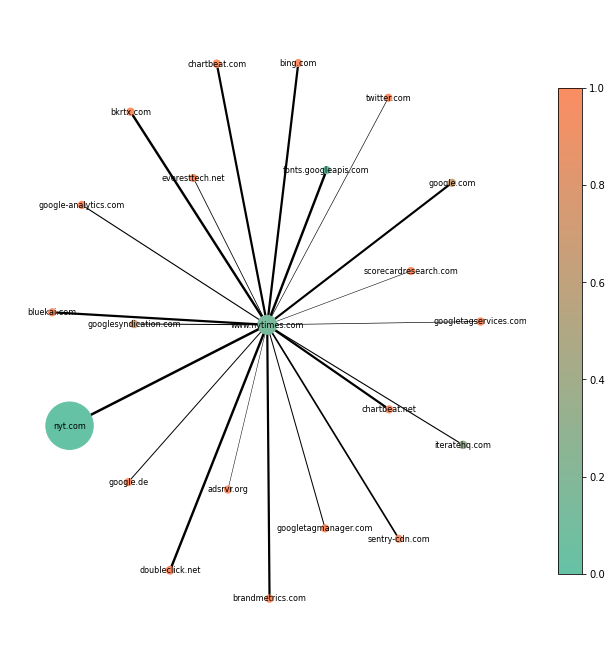

In [5]:
plot_graph('nytimes.com')

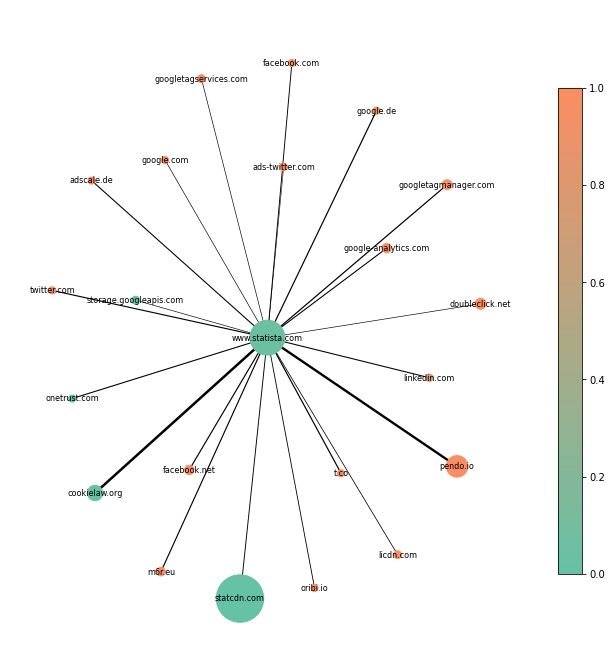

In [6]:
plot_graph('statista.com')

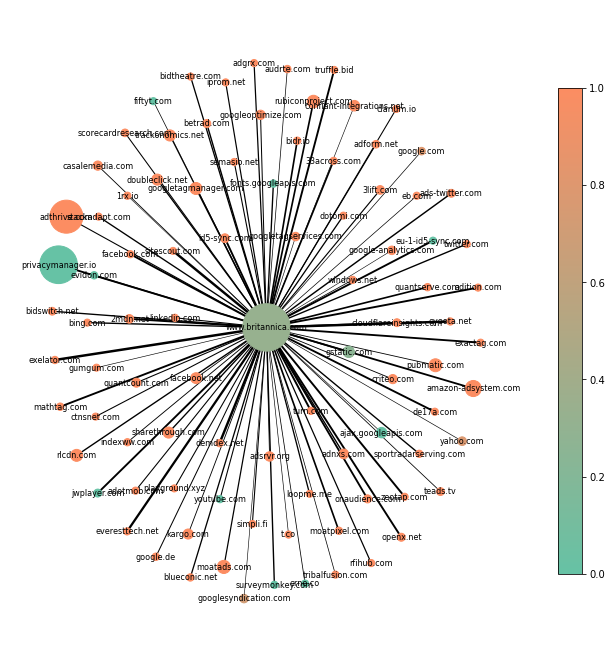

In [7]:
plot_graph('britannica.com')

In [8]:
packets = resources.explode(["packets", "sizes", "ip_src", "ip_dst", "rel_time"])
packets = packets.rename(columns={'packets': 'packet', 'sizes': 'size'})
packets['is_outgoing'] = packets['ip_src'].apply(lambda x: x.startswith('172.17'))
packets['directed_size'] = packets.apply(lambda row: -row['size'] if row['is_outgoing'] else row['size'], axis=1)
packets.head()

,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packet,hostname,is_tp,study_name,is_tracker,filter,size,ip_src,ip_dst,rel_time,outgoing,outgoing_sizes,is_outgoing,directed_size
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,20,mozilla.org,False,without-cookie,False,NaN,347,172.17.0.4,44.236.72.93,0.404504,[20],[347],True,-347
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,26,mozilla.org,False,without-cookie,False,NaN,435,44.236.72.93,172.17.0.4,0.595066,[20],[347],False,435
1,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,51,mozilla.org,False,without-cookie,False,NaN,351,172.17.0.4,13.32.119.185,0.6612,[51],[351],True,-351
1,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,59,mozilla.org,False,without-cookie,False,NaN,1460,13.32.119.185,172.17.0.4,0.6762,[51],[351],False,1460
1,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,61,mozilla.org,False,without-cookie,False,NaN,305,13.32.119.185,172.17.0.4,0.676207,[51],[351],False,305


In [9]:
packet_flow = packets.groupby(['study_name', 'website_call', 'hostname']).agg({'rel_time': list, 'directed_size': list, 'size': list, 'is_outgoing': list, 'is_tracker': list})

In [24]:
def plot_traffic_flow(study_name, website):
    length = min(24, len(packet_flow.loc[(study_name, website)]))
    fig_height = math.ceil(length / 3)*1.5
    fig, axs2d = plt.subplots(math.ceil(length / 3), 3, figsize=(12,fig_height), sharex=True, sharey=True)
    if not isinstance(axs2d[0], np.ndarray):
        axs2d = [axs2d]
    
    iterator = iter(packet_flow.loc[(study_name, website)].index)
    axs2d[0][0].scatter([],[], color=color_cycle[0], label='Non-Tracker')
    axs2d[0][0].scatter([],[], color=color_cycle[1], label='Tracker')

    for row, ax1d in enumerate(axs2d):
        for col, ax in enumerate(ax1d):
            if row == 0 and col == 0:
                host = website
            else:
                try:
                    while True:
                        host = next(iterator)
                        if host != website:
                            break
                except:
                    axs2d[row,col].set_axis_off()
                    break
                    
            data = packet_flow.loc[(study_name, website, host)]
            color = [color_cycle[1] if is_tracker else color_cycle[0] for is_tracker in data['is_tracker']]
            ax.scatter(data['rel_time'], data['directed_size'], s=12, marker='x', color=color, label=data['is_tracker'])
            color = color_cycle[4] if host == website else 'k'
            ax.set_title(host, color=color)
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.yaxis.set_tick_params(labelleft=True)
            ax.axhline(y=0, color='k', linewidth=.5)
            if row == len(axs2d) - 1:
                ax.set_xlabel("Time [s]")
            if col == 0:
                ax.set_ylabel("Flow [bytes]")

    fig.tight_layout()
    # fancybox=True, shadow=True
    fig.legend(['Non-Tracker', 'Tracker'], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=2)
    fig.savefig(ASSETS / f'{website}-traffic-flow-{study_name}{CHART_FILE_EXTENSION}', bbox_inches="tight")

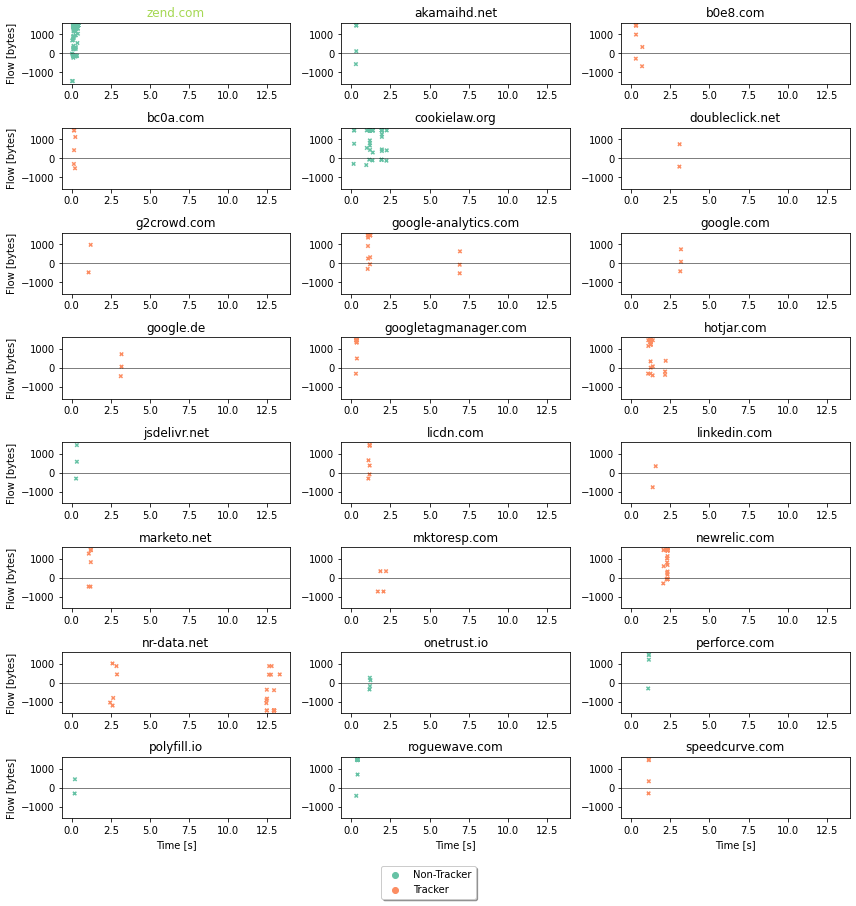

In [11]:
# good service entropy
plot_traffic_flow('with-cookie', 'zend.com')

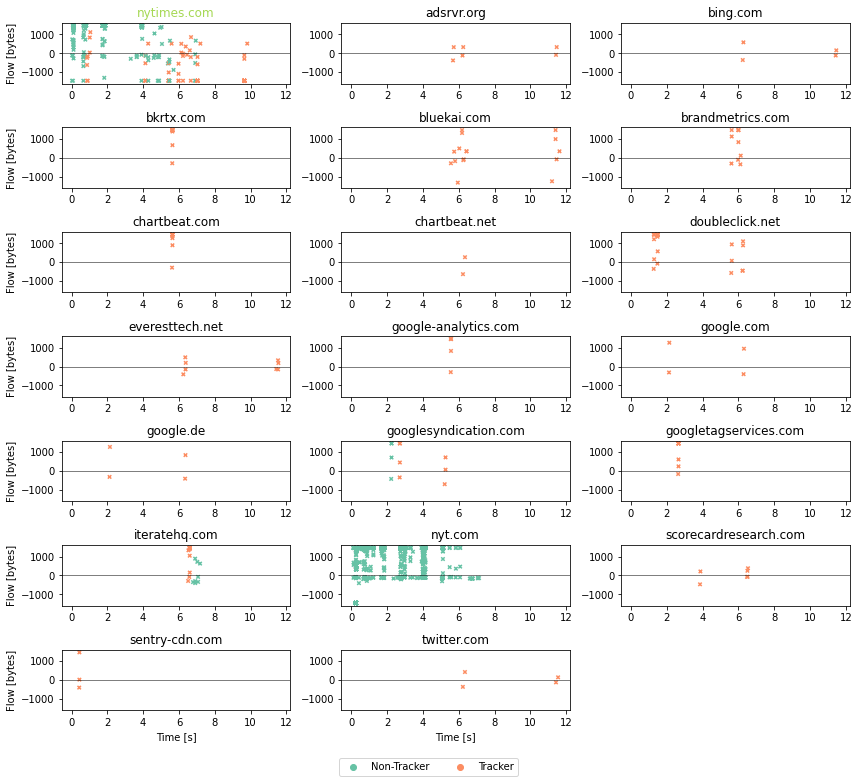

In [25]:
plot_traffic_flow('with-cookie', 'nytimes.com')

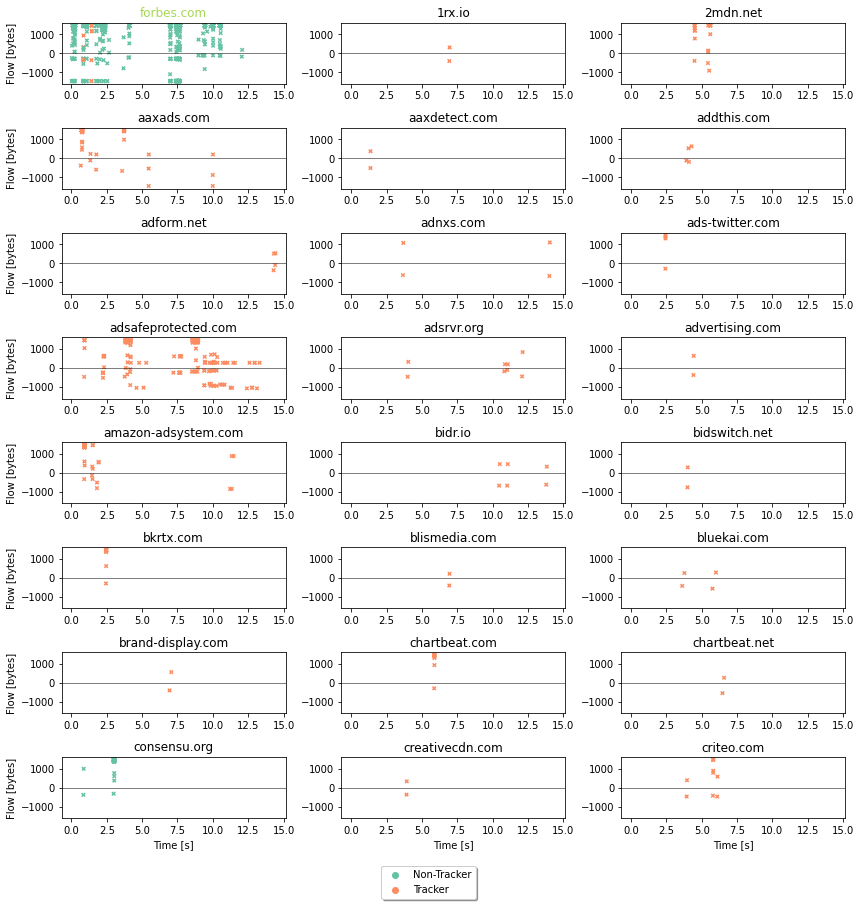

In [21]:
plot_traffic_flow('with-cookie', 'forbes.com')

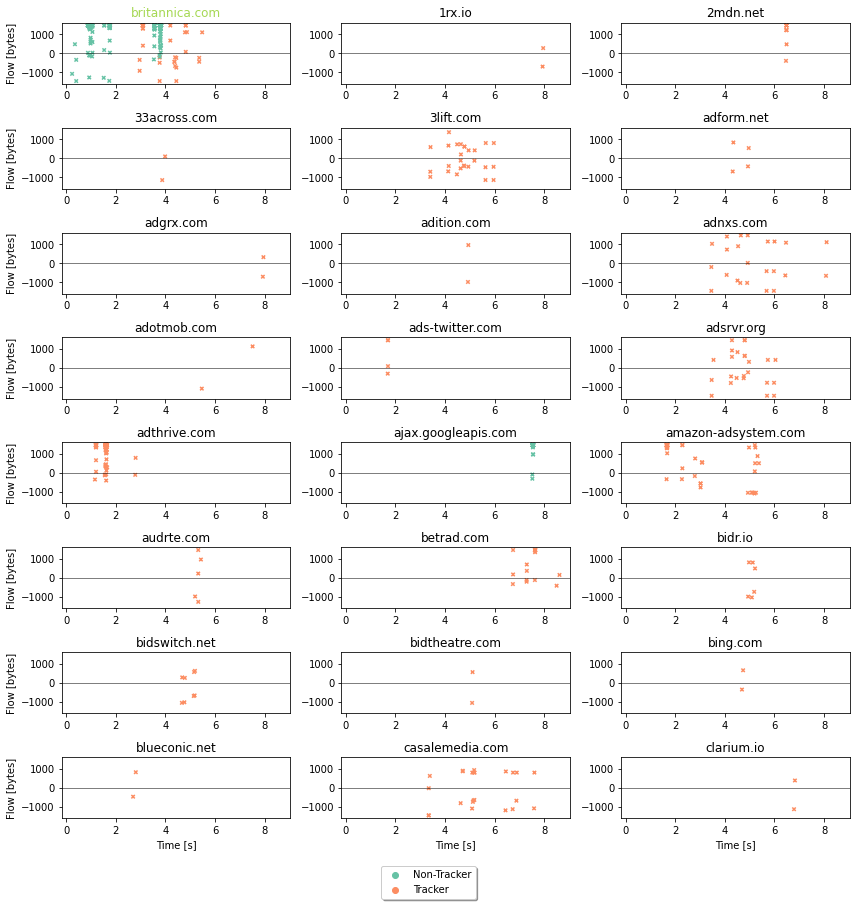

In [13]:
plot_traffic_flow('with-cookie', 'britannica.com')

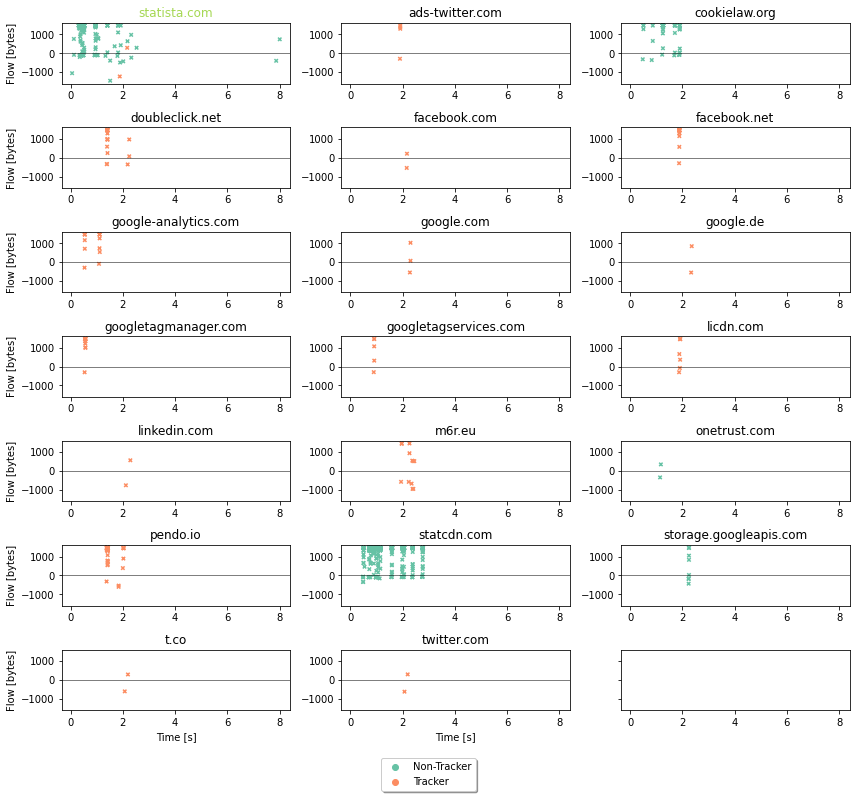

In [14]:
plot_traffic_flow('with-cookie', 'statista.com')

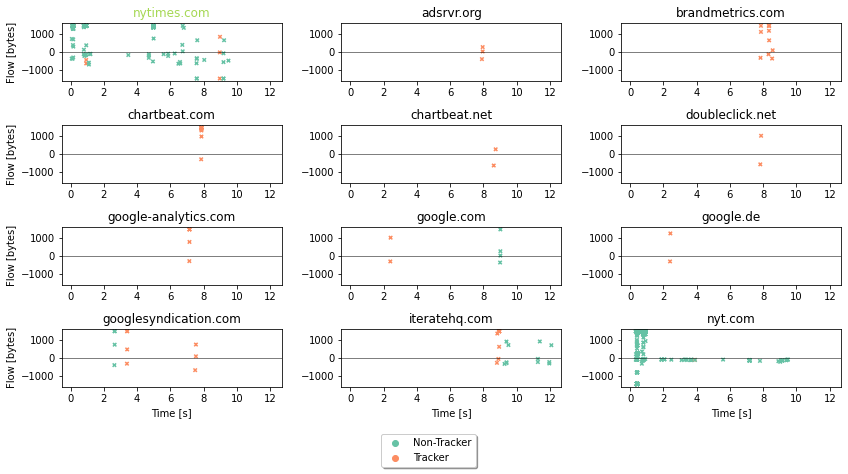

In [15]:
plot_traffic_flow('without-cookie', 'nytimes.com')

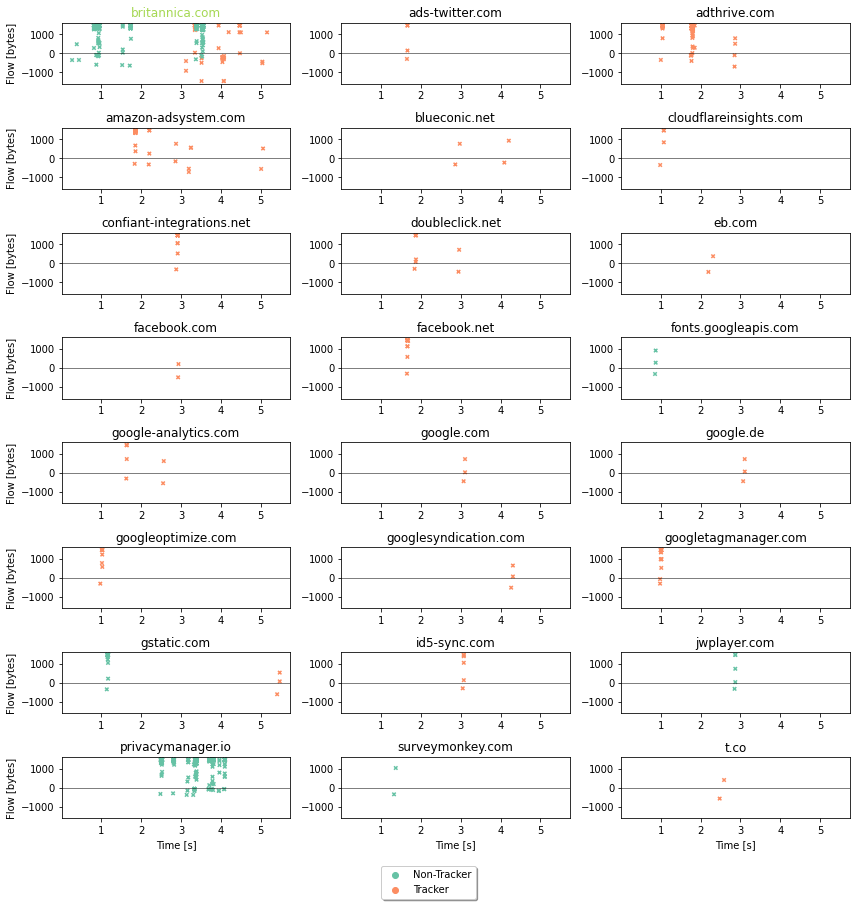

In [16]:
plot_traffic_flow('without-cookie', 'britannica.com')

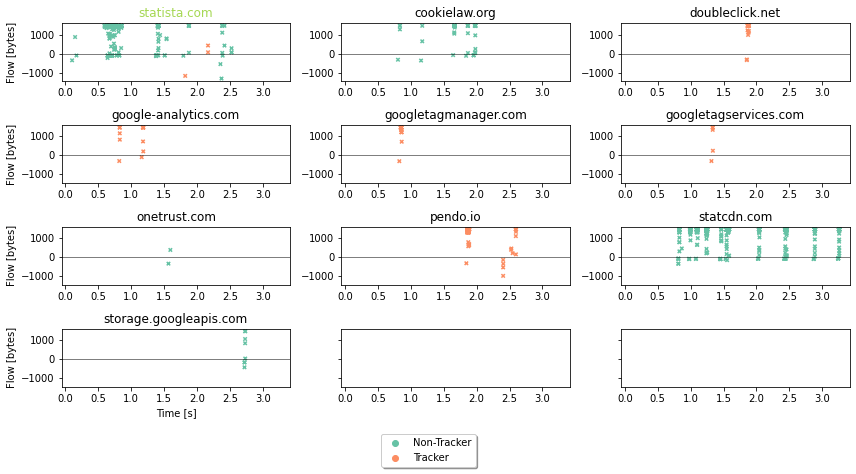

In [17]:
plot_traffic_flow('without-cookie', 'statista.com')

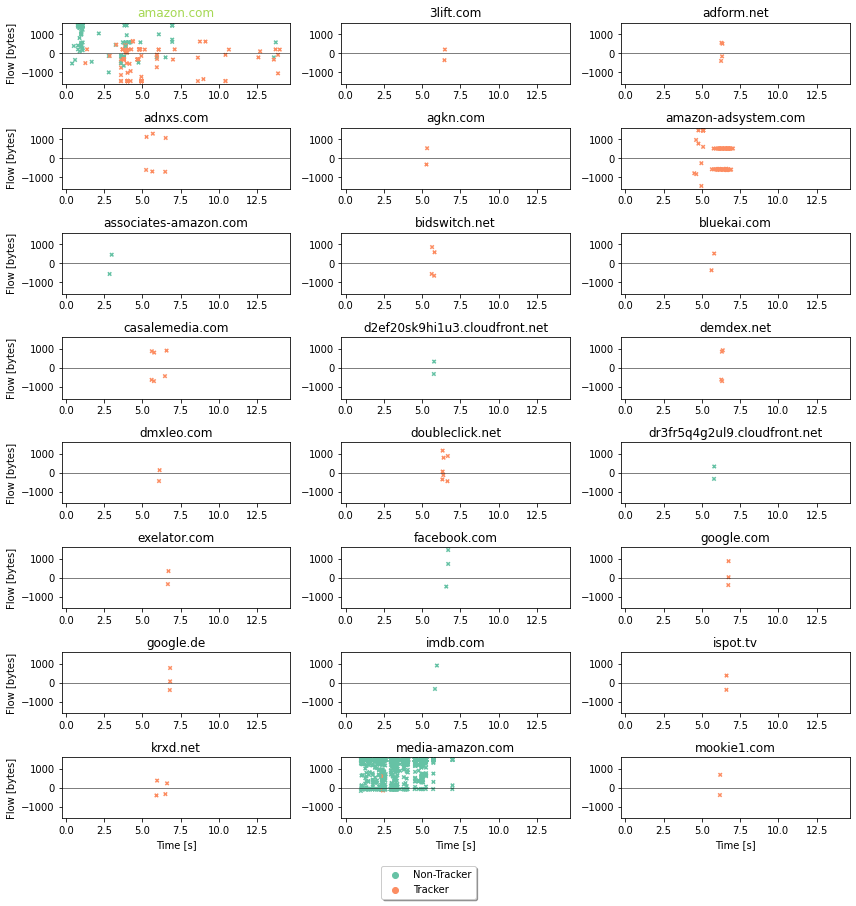

In [18]:
# good service entropy
plot_traffic_flow('without-cookie', 'amazon.com')

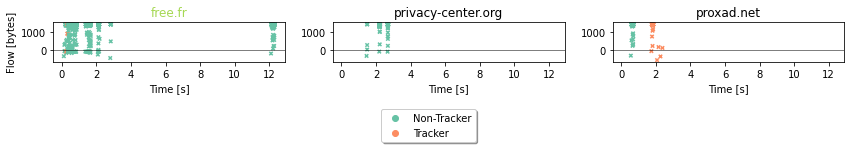

In [19]:
# bad service entropy
plot_traffic_flow('without-cookie', 'free.fr')

## Pearson Correlation

In [20]:
packet_flow['tracking_ratio'] = packet_flow['is_tracker'].apply(lambda x: sum(x) / len(x))
packet_flow['len'] = packet_flow['is_tracker'].apply(len)
stats.pearsonr(packet_flow['len'], packet_flow['tracking_ratio'])

(-0.29457773695234923, 0.0)

Pearson correlation between tracking ratio and number of packets (in a communiation link to a party) is negativ, meaning a higher packet volume (more packets) the less tracking.